In [47]:
"""
Defines one instance of a genome, which is a collection of genes and a fitness score.
 - Genes are a list of weights that are applied to each indicator to dictate whether to buy or sell.
 - Fitness is a score that is calculated by the fitness function, which is the total profit of the genome on BTC.
"""
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import random

class BuyIndicators():
	def __init__(self,data):
		self.indicators = [column for column in data.columns if "buy" in column]
		self.size = len(self.indicators)

	def __str__(self):
		return "BuyIndicators: size = {}, indicators = {}".format(self.size, self.indicators)

	def __repr__(self):
		return self.__str__()

class SellIndicators():
	def __init__(self,data):
		self.indicators = [column for column in data.columns if "sell" in column]
		self.size = len(self.indicators)

	def __str__(self):
		return "SellIndicators: size = {}, indicators = {}".format(self.size, self.indicators)

	def __repr__(self):
		return self.__str__()

class Genome():
	def __init__(self, fitness, buy_genes, sell_genes):
		self.fitness = fitness
		self.buy_genes = buy_genes
		self.sell_genes = sell_genes

	def __str__(self):
		return "Genome: fitness = {}, buy_genes = {}, sell_genes = {}".format(self.fitness, self.buy_genes, self.sell_genes)

	def __repr__(self):
		return self.__str__()

class Dataset():
	def __init__(self, data):
		self.data_name = data
		self.data = pd.read_csv("data/" +data+".csv")
		self.bollinger(5,10)
		self.bollinger(10,50)
		self.bollinger(20,50)
		self.bollinger(50,100)
		self.adx(10)
		self.adx(30)
		self.adx(50)
		self.save()
	
	def bollinger(self, short_window=10, medium_window=50):
	
		short_window = short_window ### optimization target
		medium_window = medium_window ### optimization target

		indicator_bb = BollingerBands(close=self.data["close"], window=short_window, window_dev=2)
		indicator_bb_m = BollingerBands(close=self.data["close"], window=medium_window, window_dev=2)
		df_temp = pd.DataFrame()

		# Add Bollinger Bands features
		df_temp['mavg_s'] = indicator_bb.bollinger_mavg()
		df_temp['mavg_m'] = indicator_bb_m.bollinger_mavg()

		self.data[f"bollinger_buy_{short_window}_{medium_window}"] = np.where(df_temp['mavg_m'] > df_temp['mavg_s'], 1,-1)
		self.data[f"bollinger_sell_{short_window}_{medium_window}"] = np.where(df_temp['mavg_m'] < df_temp['mavg_s'], 1,-1)

	def adx(self, short_window=10):
		short_window = short_window### optimization target
		adx_indcator = ADXIndicator(high=self.data["high"],low=self.data["low"],close=self.data["close"], window=short_window)
		temp_df = pd.DataFrame(data=[adx_indcator.adx(),adx_indcator.adx_pos(),adx_indcator.adx_neg()]).transpose()
		
		temp_df["adx_buy"] = -1
		temp_df["adx_sell"] = -1
		for i in range(len(self.data)):
			if(temp_df["adx"].iloc[i-1]<25 and temp_df["adx"].iloc[i]> 25 and temp_df["adx_pos"].iloc[i] > temp_df["adx_neg"].iloc[i]):
				temp_df["adx_buy"].iloc[i] = 1

			if(temp_df["adx"].iloc[i-1]<25 and temp_df["adx"].iloc[i]> 25 and temp_df["adx_pos"].iloc[i] < temp_df["adx_neg"].iloc[i]):
				temp_df["adx_sell"].iloc[i] = 1

		self.data[f"adx_buy_{short_window}"] = temp_df["adx_buy"]
		self.data[f"adx_sell_{short_window}"] = temp_df["adx_sell"]

	def save(self):
		self.data.to_csv("data/" +self.data_name+"_processed.csv", index=False)
	
	def __str__(self):
		return "Dataset: size = {}".format(len(self.data))

	def __repr__(self):
		return self.__str__()
Dataset("BTC")

c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\kaneb.DESKTOP-A94UFDN\AppData\Local\Programs\Python\Python39\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 

Dataset: size = 719

In [48]:
import copy
best_genome = None
class TrainGenomes():
	def __init__(self, population_size, data_name, generations):
		self.population_size = population_size
		try:
			self.data = pd.read_csv("data/" +data_name+"_processed.csv")
		except:
			print("Dataset not found, please create one!")
			quit(1)
		self.generations = generations
		self.buy_genes = BuyIndicators(self.data)
		self.sell_genes = SellIndicators(self.data)

	def train(self):
		global best_genome
		# Initialize the population
		population = self.initialize_population(self.population_size, self.buy_genes, self.sell_genes)
		# Evaluate the population
		for i in range(self.generations):
			population = self.evaluate_population(population)
			# Sort the population by fitness
			population.sort(key=lambda x: x.fitness, reverse=True)
			# # Keep track of the best genome
			self.save_population(population,f"pre_genomes.csv")
			print(f"Generation {i} best genome fitness: {population[0].fitness}, average fitness: {np.mean([x.fitness for x in population])}")
			best_genome = population[0]
			# Seperate elite from population
			# do tournament selection for next generation
			population = self.tournament_selection(population, 0.05,2)
			# # Add the elite to the population
			# population.extend(elite)
			population.sort(key=lambda x: x.fitness, reverse=True)
			self.save_population(population,f"post_genomes.csv")
		
		# # Keep track of the number of generations with no improvement
		# no_improvement = 0
		# # Keep track of the number of generations
		# generations = 0
		# # Keep track of the time
		# start_time = time.time()
		# Keep track of the best fitness
	def save_population(self,population,name):
		#save list of population classes as csv
		lst = [x.__dict__ for x in population]
		pd.DataFrame(lst).to_csv(f"{name}.csv")


	def initialize_population(self, population_size, buy_genes, sell_genes):
		population = []
		for i in range(population_size):
			buy_genes = np.random.uniform(-1,1,buy_genes.size)
			sell_genes = np.random.uniform(-1,1,sell_genes.size)
			population.append(Genome(0, buy_genes, sell_genes))

		return population
	
	def evaluate_population(self, population):
		for genome in population:
			genome.fitness = self.fitness(genome)
		return population
	
	def fitness(self, genome):
		buying = True
		fiat_money = 100
		btc_money = 0
		fee = 0.02 # Each buy or sell event costs 2% of current holdings.
		
		#Create a buy and sell dataframe using the genomes weights and the indicators status
		temp_df = pd.DataFrame()
		for i,indicator in enumerate(self.buy_genes.indicators):
			try:
				temp_df["buy"] += self.data[indicator] * genome.buy_genes[i]
			except KeyError:
				temp_df["buy"] = self.data[indicator] * genome.buy_genes[i]

		for i,indicator in enumerate(self.sell_genes.indicators):
			try:
				temp_df["sell"] += self.data[indicator] * genome.sell_genes[i]
			except KeyError:
				temp_df["sell"] = self.data[indicator] * genome.sell_genes[i]
		
		for index, row in self.data.iterrows():
			if buying:
				if temp_df.iloc[index]["buy"] > 0:
					btc_money = ( fiat_money / row['close'] ) * (1 - fee)
					fiat_money = 0
					buying = False

			elif temp_df.iloc[index]["sell"] > 0:
					fiat_money = (btc_money * row['close'] ) * (1 - fee)
					btc_money = 0
					buying = True
		
		return fiat_money + (btc_money * self.data.iloc[-1]['close'])
	
	def tournament_selection(self, population, elitism, tournament_size):
		# Select elite
		elite = population[:int(elitism*len(population))]
		# Initialize an empty list for the parents
		parents = []
		for _ in range(len(population) - len(elite)):
			# Randomly select tournament_size genomes
			tournament = np.random.choice(population, size=tournament_size)
			# Select the best genome
			winner = copy.deepcopy(max(tournament, key=lambda x: x.fitness))
			winner.buy_genes += np.random.uniform(-0.05, 0.05, winner.buy_genes.size)
			winner.sell_genes += np.random.uniform(-0.05, 0.05, winner.sell_genes.size)
			# Add the winner to the parents list
			parents.append(winner)
		# Add the elite to the parents list
		parents.extend(elite)
		return parents

	def mutate_population(self, population, genome_mutation_probability, gene_mutation_probability):
		# Mutate the genomes
		for genome in population:
			if np.random.uniform() < genome_mutation_probability:
				for i in range(genome.buy_genes.size):
					if np.random.uniform() < gene_mutation_probability:
						genome.buy_genes[i] += np.random.uniform(-0.05, 0.05)
				for i in range(genome.sell_genes.size):
					if np.random.uniform() < gene_mutation_probability:
						genome.sell_genes[i] += np.random.uniform(-0.05, 0.05)
	
		return population



TrainGenomes(500, "BTC",50).train()



Generation 0 best genome fitness: 152.90534377780526, average fitness: 20.278107053967524
Generation 1 best genome fitness: 152.90534377780526, average fitness: 40.39303826827978
Generation 2 best genome fitness: 152.90534377780526, average fitness: 62.88127156433556
Generation 3 best genome fitness: 152.90534377780526, average fitness: 80.88759274123424
Generation 4 best genome fitness: 152.90534377780526, average fitness: 97.43520737703994
Generation 5 best genome fitness: 152.90534377780526, average fitness: 107.90422847574452
Generation 6 best genome fitness: 152.90534377780526, average fitness: 118.73427246027445
Generation 7 best genome fitness: 152.90534377780526, average fitness: 129.15149251226757
Generation 8 best genome fitness: 155.08331636182163, average fitness: 141.14843582861948
Generation 9 best genome fitness: 159.96356058299784, average fitness: 148.89154129533716
Generation 10 best genome fitness: 159.96356058299784, average fitness: 147.146725195489
Generation 11 b

KeyboardInterrupt: 

In [49]:
print(best_genome)

Genome: fitness = 169.84497063216386, buy_genes = [0.16218436 0.67272146 0.70842381 0.05189443 0.51444841 0.64285652
 0.74946518], sell_genes = [-0.18890517 -0.3888065  -0.73239885  0.42679187  1.06608341 -0.76270293
  0.45604671]


Genome: fitness = 169.84497063216386, buy_genes = [0.16218436 0.67272146 0.70842381 0.05189443 0.51444841 0.64285652
 0.74946518], sell_genes = [-0.18890517 -0.3888065  -0.73239885  0.42679187  1.06608341 -0.76270293
  0.45604671]


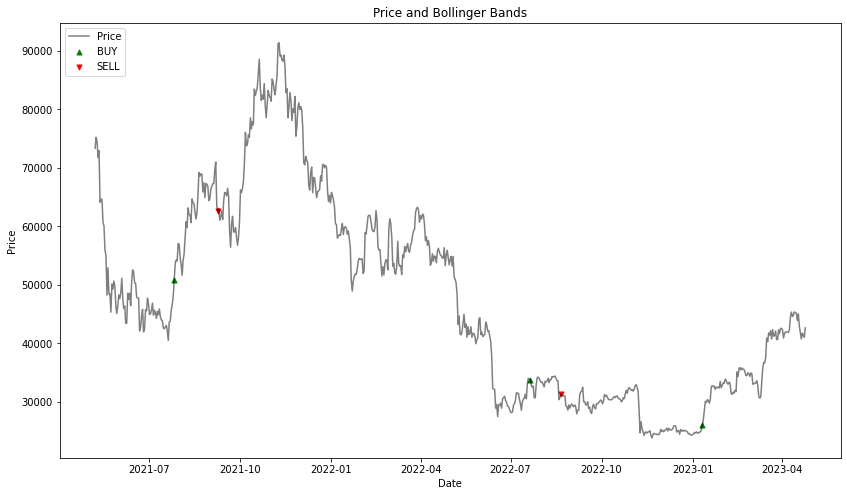

169.84497063216386

In [52]:

import matplotlib.pyplot as plt
class ExamineGenome():
    def __init__(self, genome, data_name):
        self.genome = genome
        try:
            self.data = pd.read_csv("data/" +data_name+"_processed.csv")
        except:
            print("Dataset not found, please create one!")
            quit(1)
        self.buy_genes = BuyIndicators(self.data)
        self.sell_genes = SellIndicators(self.data)
        self.data["timestamp"] = pd.to_datetime(self.data['timestamp'])
    def examine(self):
        buying = True
        fiat_money = 100
        btc_money = 0
        fee = 0.02 # Each buy or sell event costs 2% of current holdings.
        #Create a buy and sell dataframe using the genomes weights and the indicators status
        temp_df = pd.DataFrame()
        buys = [[],[]]
        sells = [[],[]]
        for i,indicator in enumerate(self.buy_genes.indicators):
            try:
                temp_df["buy"] += self.data[indicator] * self.genome.buy_genes[i]
            except KeyError:
                temp_df["buy"] = self.data[indicator] * self.genome.buy_genes[i]

        for i,indicator in enumerate(self.sell_genes.indicators):
            try:
                temp_df["sell"] += self.data[indicator] * self.genome.sell_genes[i]
            except KeyError:
                temp_df["sell"] = self.data[indicator] * self.genome.sell_genes[i]

        for index, row in self.data.iterrows():
            if buying:
                if temp_df.iloc[index]["buy"] > 0:
                    buys[0].append(row['timestamp'])
                    buys[1].append(row['close'])
                    btc_money = ( fiat_money / row['close'] ) * (1 - fee)
                    fiat_money = 0
                    buying = False

            elif temp_df.iloc[index]["sell"] > 0:
                    sells[0].append(row['timestamp'])
                    sells[1].append(row['close'])
                    fiat_money = (btc_money * row['close'] ) * (1 - fee)
                    btc_money = 0
                    buying = True
        
        plt.figure(figsize=(14, 8))
        plt.title('Price and Bollinger Bands')
        plt.scatter(buys[0], buys[1], label='BUY', color='green', s=25, marker="^")
        plt.scatter(sells[0], sells[1], label='SELL', color='red', s=25, marker="v")
        plt.plot(self.data['timestamp'], self.data['close'], label='Price', alpha=0.5, color='black')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(loc='upper left')
        plt.show()
        return fiat_money + (btc_money * self.data.iloc[-1]['close'])
print(best_genome)
ExamineGenome(best_genome, "BTC").examine()